# Twin4Build: Basic Usage Example

Welcome to this tutorial on using the Twin4Build package! In this notebook, you'll learn how to:
1. Create a simple model with a schedule and a damper
2. Connect components in the model
3. Simulate the model
4. Visualize the results

This example demonstrates the basic workflow for creating and simulating a building model in Twin4Build. We'll create a simple ventilation system with a damper controlled by a schedule.

Let's get started!

## 1. Setup
First, let's install and import the necessary packages. If you're running this in Google Colab, uncomment the pip install line.
Note that colab has a dependency issue and asks you to restart the runtime. It will work after you restart the runtime and run the cell a 2nd time.  

In [1]:
# %pip install twin4build # Uncomment in google colab
import twin4build as tb
import datetime
from dateutil import tz

## Creating the Model

Now that we have our packages installed and imported, let's create a simple model. The model will represent a basic ventilation system with a damper controlled by a schedule.

In [2]:
# Create a new model
model = tb.Model(id="minimal_example")
print(model)

+-------------------------------------------------------------------------------------------------------------------------+
|                                          Model overview    id: minimal_example                                          |
+---------------------------------------------+---------------------------------------------------------------------------+
|  Number of components in simulation model:  |                                     0                                     |
+---------------------------------------------+---------------------------------------------------------------------------+
| Number of connections in simulation model:  |                                     0                                     |
+---------------------------------------------+---------------------------------------------------------------------------+
|              Model directory:               | C:\Users\jabj\AppData\Local\Temp\1\generated_files\models\minimal_example |
+-------

C:\Users\jabj\Documents\python\Twin4Build\twin4build\utils\mkdir_in_root.py:10: MainPathNotFound: Could not determine main module path, using temp dir: C:\Users\jabj\AppData\Local\Temp\1
  current_dir = get_main_dir()


### Instantiating Components
As shown by the printout, the model is currently empty. Let's add two components:
1. A schedule that will control the damper position
2. A damper that will control the airflow

The schedule will output values between 0 and 1, where:
- 0 means the damper is fully closed
- 1 means the damper is fully open

The damper will convert this position into an actual airflow rate based on its characteristics.

Note that any class in the Twin4Build package ending with "System" can be used as a component. Here are some examples of available components. The full list of available components is available in the [Twin4Build documentation](https://twin4build.readthedocs.io/en/latest/auto/twin4build.systems.html):

In [3]:
tb.ScheduleSystem
tb.AirToAirHeatRecoverySystem
tb.FanTorchSystem

twin4build.systems.fan.fan_torch_system.FanTorchSystem

In [4]:
# 1. Create a schedule
position_schedule = tb.ScheduleSystem(
    weekDayRulesetDict = {
        "ruleset_default_value": 0,
        "ruleset_start_minute": [0,0,0,0,0,0,0],
        "ruleset_end_minute": [0,0,0,0,0,0,0],
        "ruleset_start_hour": [6,7,8,12,14,16,18],
        "ruleset_end_hour": [7,8,12,14,16,18,22],
        "ruleset_value": [0,0.1,1,0,0,0.5,0.7]
    },
    id="PositionSchedule"
)
print("Schedule component:")
print(position_schedule)

# 2. Create a damper
damper = tb.DamperTorchSystem(
    nominalAirFlowRate=1.6,
    a=5,
    id="Damper"
)
print("\nDamper component:")
print(damper)

Schedule component:
+--------------------------------------------+
| Component overview    id: PositionSchedule |
+------------+-------------------------------+
|   input    |             output            |
+------------+-------------------------------+
|            |         scheduleValue         |
+------------+-------------------------------+

Damper component:
+----------------------------------+
| Component overview    id: Damper |
+----------------+-----------------+
|     input      |      output     |
+----------------+-----------------+
| damperPosition |  damperPosition |
+----------------+-----------------+
|                |   airFlowRate   |
+----------------+-----------------+


### Connecting Components

Now that we have our components, let's connect them in the model. The connection will:
1. Take the output from the schedule ("scheduleValue")
2. Use it as input to the damper ("damperPosition")

In [5]:
# Connect the schedule's output to the damper's input
model.add_connection(position_schedule, damper, "scheduleValue", "damperPosition")

# model.add_connection(damper, damper, "damperPosition", "damperPosition") #Test add connection
# model.remove_connection(damper, damper, "damperPosition", "damperPosition") #Test remove connection

print("Components connected successfully!")

# Let's see our updated model
print("\nUpdated model:")
print(model)

Components connected successfully!

Updated model:
+-------------------------------------------------------------------------------------------------------------------------+
|                                          Model overview    id: minimal_example                                          |
+---------------------------------------------+---------------------------------------------------------------------------+
|  Number of components in simulation model:  |                                     2                                     |
+---------------------------------------------+---------------------------------------------------------------------------+
| Number of connections in simulation model:  |                                     1                                     |
+---------------------------------------------+---------------------------------------------------------------------------+
|              Model directory:               | C:\Users\jabj\AppData\Local\Temp\

### Loading Model
Before we can simulate the model, we need to load it. This step:
1. Validates the model structure
2. Prepares the components for simulation
3. Checks for any missing connections or parameters
4. Creates the simulation graph

In [6]:
model.load()


Loading model...[OK]
   |___Loading simulation model...[OK]
   |   |
   |   |___Removing cycles...[OK]
   |   |___Determining execution order...[OK]
   |   |___Loading parameters...[OK]
   |   |
   |   |___Validating model...[OK]
   |   |   |
   |   |   |___Validated for Simulator...[OK]
   |   |   |___Validated for Estimator...[OK]
   |   |   |___Validated for Optimizer...[OK]
   |
   |___Drawing simulation model...[OK]


Model loaded


### Visualizing the Model (not required)
We can visualize the model to see the components and connections.<br>
This is not required, but it can be helpful for debugging and for building the model.<br>
The green nodes in the graph represent components, and the blue nodes (Connection, ConnectionPoint) represent the output and input ports.

In [7]:
from IPython.display import Image
sim_graph = model.get_dir(folder_list=["simulation_model", "semantic_model", "graphs"], filename="semantic_model.png")[0]
Image(filename=sim_graph) 


## 3. Simulating the Model

Now that our model is set up, let's simulate it for a 2-day period. The simulation will:
1. Step through time in 10-minute intervals (600 seconds)
2. Calculate the damper position based on the schedule
3. Calculate the resulting airflow rate
4. Store the results for visualization

In [8]:
# Set up the simulator and simulation parameters
simulator = tb.Simulator(model)
step_size = 600  # Seconds
start_time = datetime.datetime(year=2024, month=1, day=10, hour=0, minute=0, second=0, tzinfo=tz.gettz("Europe/Copenhagen"))
end_time = datetime.datetime(year=2024, month=1, day=12, hour=0, minute=0, second=0, tzinfo=tz.gettz("Europe/Copenhagen"))

# Simulate the model
simulator.simulate(step_size=step_size,
                    start_time=start_time,
                    end_time=end_time)
print("Simulation completed successfully!")

100%|██████████| 288/288 [00:00<00:00, 11182.53it/s]

Simulation completed successfully!


## 4. Visualizing the Results

Finally, let's visualize the results of our simulation. We'll create a plot showing:
1. The airflow rate through the damper (primary axis)
2. The damper position (secondary axis)

This helps us understand how the schedule affects the damper position and resulting airflow.

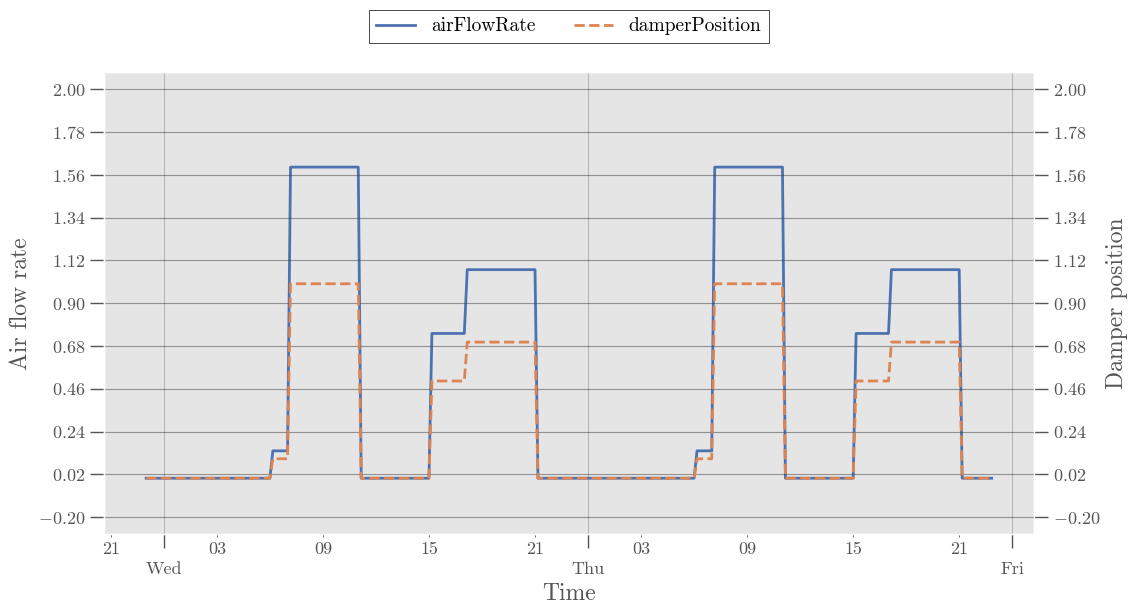

Plot generated successfully!


In [9]:
# Plot the damper results
# plot.plot_damper(model, simulator, "Damper", show=True)
tb.plot.plot_component(simulator,
                    components_1axis=[("Damper", "airFlowRate", "output")], 
                    components_2axis=[("Damper", "damperPosition", "output")], 
                    ylabel_1axis="Air flow rate", #Optional
                    ylabel_2axis="Damper position", #Optional
                    show=True,
                    nticks=11)
print("Plot generated successfully!")

## Conclusion

Congratulations! You've successfully created a simple Twin4Build model, simulated it, and visualized the results. 

In this tutorial, you learned how to:
1. Create a model and add components (schedule and damper)
2. Connect components in the model
3. Set up and run a simulation
4. Visualize the simulation results

Next steps:
- Try adding more components to create more complex models
- Experiment with different schedules and parameter values
- Explore other visualization options in the `plot` module
- Check out the other example notebooks for more advanced features:
  - Parameter estimation: Learn how to calibrate model parameters
  - Neural policy control: Implement AI-based control strategies
  - CO2 control: Model and control indoor air quality
  - Space heating: Create thermal comfort control systems

For more advanced usage and detailed documentation, please refer to the Twin4Build documentation.

### Troubleshooting Tips
- If you get import errors, make sure Twin4Build is properly installed
- If components fail to connect, check that the input/output names match exactly
- If simulation fails, verify that all required parameters are set
- If plotting fails, ensure the component IDs match those in your model

### Performance Tips
- Use appropriate step sizes for your simulation (smaller steps = more accurate but slower)
- Only save simulation results for components you need to analyze
- Use the plot_component function for efficient visualization
- Consider using semantic models for complex building systems